<a href="https://colab.research.google.com/github/s34836/EWD/blob/main/Lab_Model_Selection%2C_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection, regularization

## Tasks
1. Load the `Hitters.csv` dataset. Select the best model for predicting  `Salary` using *forward/backward selection*.
    - Ignore the `PlayerName` column. Remove rows containing missing values.
    - Encode categorical variables using [`get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).
    - Standardize the inputs (X) ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)/[`scale()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)).
    - Split the data into a training and test set.
    - You can implement forward/backward selection manually or use the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html).
    - Select the best model and output the test MSE.


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('Hitters.csv')

# Remove PlayerName column and rows with missing values
df = df.drop('PlayerName', axis=1)
df = df.dropna()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [16]:
# Separate features and target
X = df.drop('Salary', axis=1)
y = df['Salary']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)
X_encoded.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,0,1,0


In [17]:
print(X_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(263, 19)


In [18]:
# Initialize model
lr = LinearRegression()

# Forward selection with cross-validation
print("Performing forward selection...")
forward_selector = SequentialFeatureSelector(
    lr,
    n_features_to_select='auto',
    direction='forward',
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

forward_selector.fit(X_train_scaled, y_train)
forward_features = forward_selector.get_support()
forward_feature_names = X_encoded.columns[forward_features].tolist()

print("Features:")
print(forward_feature_names)

# Backward selection with cross-validation
print("\nPerforming backward selection...")
backward_selector = SequentialFeatureSelector(
    lr,
    n_features_to_select='auto',
    direction='backward',
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

backward_selector.fit(X_train_scaled, y_train)
backward_features = backward_selector.get_support()
backward_feature_names = X_encoded.columns[backward_features].tolist()

print("Features:")
print(backward_feature_names)

Performing forward selection...
Features:
['AtBat', 'Hits', 'HmRun', 'RBI', 'Walks', 'CRBI', 'PutOuts', 'League_N', 'Division_W']

Performing backward selection...
Features:
['AtBat', 'Hits', 'HmRun', 'Walks', 'CAtBat', 'CRuns', 'PutOuts', 'League_N', 'Division_W', 'NewLeague_N']


In [19]:
# Forward model
lr_forward = LinearRegression()
lr_forward.fit(X_train_scaled[:, forward_features], y_train)
y_pred_forward = lr_forward.predict(X_test_scaled[:, forward_features])
mse_forward = mean_squared_error(y_test, y_pred_forward)

# Backward model
lr_backward = LinearRegression()
lr_backward.fit(X_train_scaled[:, backward_features], y_train)
y_pred_backward = lr_backward.predict(X_test_scaled[:, backward_features])
mse_backward = mean_squared_error(y_test, y_pred_backward)

# Full model
lr_full = LinearRegression()
lr_full.fit(X_train_scaled, y_train)
y_pred_full = lr_full.predict(X_test_scaled)
mse_full = mean_squared_error(y_test, y_pred_full)

# Results
print(f"\n=== RESULTS ===")
print(f"Forward Selection MSE: {mse_forward:.2f}")
print(f"Backward Selection MSE: {mse_backward:.2f}")
print(f"Full Model MSE: {mse_full:.2f}")


=== RESULTS ===
Forward Selection MSE: 149846.66
Backward Selection MSE: 154314.87
Full Model MSE: 150406.58


Najlepszy model: Forward Selection

Test MSE: 149,846.66

2. For the dataset in Task 1 create the [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) models.
    - Use cross validation to select the best `alpha` value. Try alphas of different orders of magnitude. Use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)/[`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).
    - Create a plot showing how the MSE varies for different values of `alpha` for both Ridge and Lasso regression. (Using a log scale for `alpha` may improve legibility).
    - (Optionally) create a plot showing how the Ridge/Lasso coefficients vary for different values of `alpha`.
    - Compare the feature subset selected by `Lasso` with the subset selected in Task 1.


In [20]:
alphas = np.logspace(-4, 4, 50)  # 10^-4 ----- 10^4

# Ridge Regression with CV
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
best_ridge_alpha = ridge_cv.alpha_

print(f"Best Ridge alpha: {best_ridge_alpha:.4f}")

Best Ridge alpha: 109.8541


In [21]:
# Lasso Regression with CV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=2000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
best_lasso_alpha = lasso_cv.alpha_

print(f"Best Lasso alpha: {best_lasso_alpha:.4f}")

Best Lasso alpha: 5.4287


In [24]:
# Test performance
ridge_pred = ridge_cv.predict(X_test_scaled)
lasso_pred = lasso_cv.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f"\nMSE Test dataset:")
print(f"Ridge: {ridge_mse:.2f}")
print(f"Lasso: {lasso_mse:.2f}")


MSE Test dataset:
Ridge: 158223.58
Lasso: 153357.92


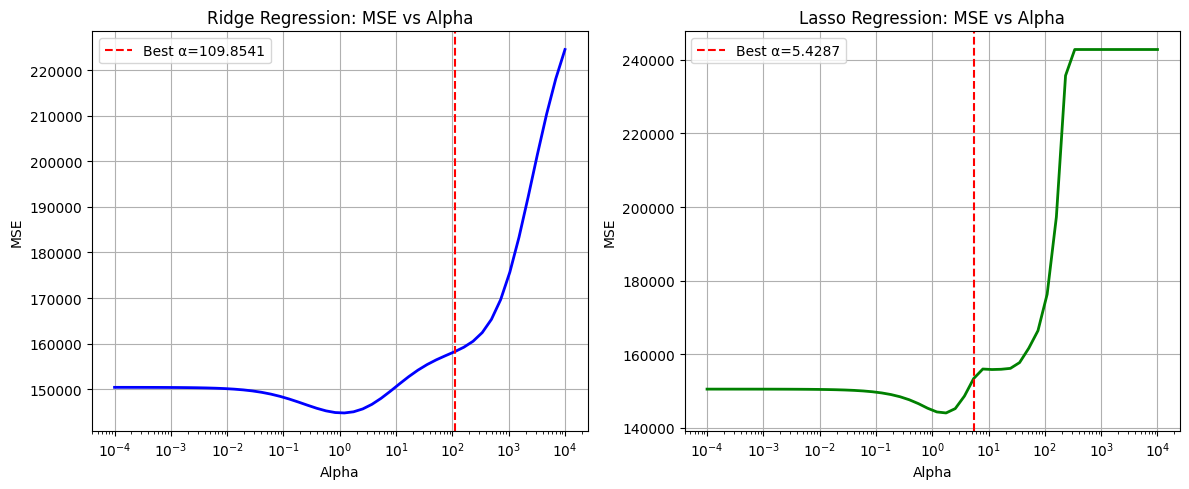

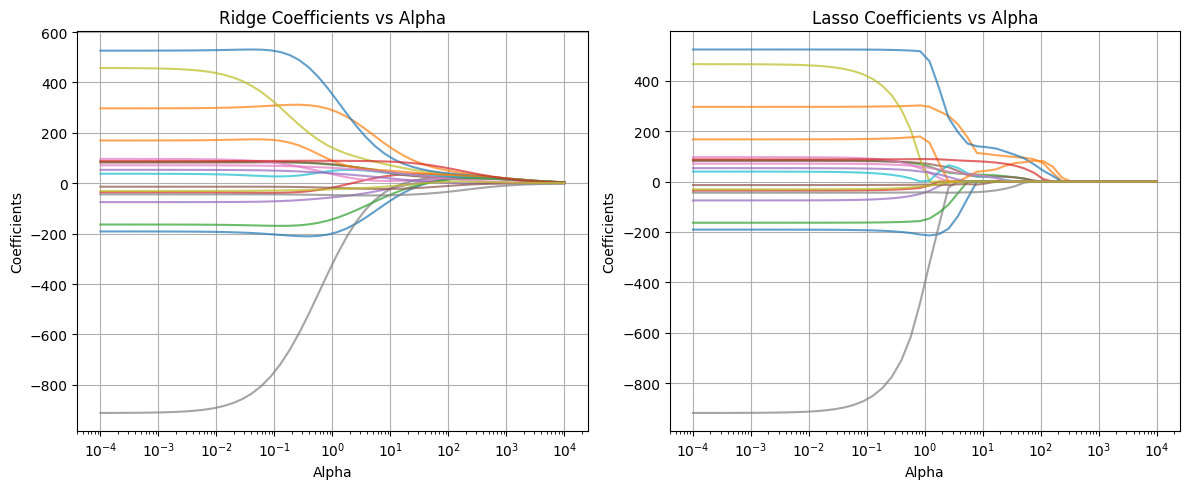

In [26]:
# Plot MSE vs Alpha
plt.figure(figsize=(12, 5))

# Ridge plot
plt.subplot(1, 2, 1)
ridge_mse_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    pred = ridge.predict(X_test_scaled)
    mse = mean_squared_error(y_test, pred)
    ridge_mse_scores.append(mse)

plt.semilogx(alphas, ridge_mse_scores, 'b-', linewidth=2)
plt.axvline(best_ridge_alpha, color='red', linestyle='--', label=f'Best α={best_ridge_alpha:.4f}')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression: MSE vs Alpha')
plt.legend()
plt.grid(True)

# Lasso plot
plt.subplot(1, 2, 2)
lasso_mse_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=2000)
    lasso.fit(X_train_scaled, y_train)
    pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, pred)
    lasso_mse_scores.append(mse)

plt.semilogx(alphas, lasso_mse_scores, 'g-', linewidth=2)
plt.axvline(best_lasso_alpha, color='red', linestyle='--', label=f'Best α={best_lasso_alpha:.4f}')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso Regression: MSE vs Alpha')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Coefficient plots
plt.figure(figsize=(12, 5))

# Ridge coefficients
plt.subplot(1, 2, 1)
ridge_coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)
for i in range(ridge_coefs.shape[1]):
    plt.semilogx(alphas, ridge_coefs[:, i], alpha=0.7)

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients vs Alpha')
plt.grid(True)

# Lasso coefficients
plt.subplot(1, 2, 2)
lasso_coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=2000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)
for i in range(lasso_coefs.shape[1]):
    plt.semilogx(alphas, lasso_coefs[:, i], alpha=0.7)

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:


# Compare Lasso selected features with Task 1
lasso_coef = lasso_cv.coef_
lasso_selected = X_encoded.columns[lasso_coef != 0].tolist()

print(f"\n=== FEATURE COMPARISON ===")
print(f"Forward Selection features ({len(forward_feature_names)}): {forward_feature_names}")
print(f"Lasso selected features ({len(lasso_selected)}): {lasso_selected}")

# Find common and different features
common_features = set(forward_feature_names) & set(lasso_selected)
forward_only = set(forward_feature_names) - set(lasso_selected)
lasso_only = set(lasso_selected) - set(forward_feature_names)

print(f"\nCommon features ({len(common_features)}): {list(common_features)}")
print(f"Forward only ({len(forward_only)}): {list(forward_only)}")
print(f"Lasso only ({len(lasso_only)}): {list(lasso_only)}")

# Feature importance comparison
print(f"\n=== LASSO COEFFICIENTS ===")
for feature, coef in zip(X_encoded.columns, lasso_coef):
    if coef != 0:
        print(f"{feature}: {coef:.4f}")


=== FEATURE COMPARISON ===
Forward Selection features (9): ['AtBat', 'Hits', 'HmRun', 'RBI', 'Walks', 'CRBI', 'PutOuts', 'League_N', 'Division_W']
Lasso selected features (11): ['AtBat', 'Hits', 'HmRun', 'Walks', 'CHmRun', 'CRuns', 'CRBI', 'PutOuts', 'Errors', 'League_N', 'Division_W']

Common features (8): ['Hits', 'Walks', 'Division_W', 'League_N', 'HmRun', 'PutOuts', 'AtBat', 'CRBI']
Forward only (1): ['RBI']
Lasso only (3): ['CRuns', 'CHmRun', 'Errors']

=== LASSO COEFFICIENTS ===
AtBat: -67.4164
Hits: 175.5090
HmRun: 29.8629
Walks: 25.4034
CHmRun: 33.1294
CRuns: 150.7299
CRBI: 19.2307
PutOuts: 82.0081
Errors: -10.0326
League_N: 29.7328
Division_W: -42.7249


MSE:

Forward Selection: 149,847 <- the best

Full Model: 150,407

Lasso: 153,358

Backward Selection: 154,314

Ridge: 158,224 <- lipa

3. Classify the data in `wdbc.data` using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use cross validation to select `C` (the regularization parameter) and the regularization method `l1`/`l2`.
    - Scale the data and split it into a training and test set.
    - Use `GridSearchCV` or [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to select the best model.
    - Create a plot showing how the cross-validated accuracy varies with `C` for both `l1` and `l2` regularization.
    - Use the test data to evaluate the best model.

In [31]:

column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df = pd.read_csv('wdbc.data', header=None, names=column_names)

df.head()

,id,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [37]:
# Prepare data
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})  # Malignant=1, Benign=0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [38]:
C_values = np.logspace(-4, 4, 20)  # 10^-4 to 10^4


# L1 Reg.
lr_l1_cv = LogisticRegressionCV(
    Cs=C_values,
    penalty='l1',
    solver='liblinear',
    cv=5,
    scoring='accuracy',
    random_state=42,
    max_iter=1000
)
lr_l1_cv.fit(X_train_scaled, y_train)

# L2 Reg.
lr_l2_cv = LogisticRegressionCV(
    Cs=C_values,
    penalty='l2',
    cv=5,
    scoring='accuracy',
    random_state=42,
    max_iter=1000
)
lr_l2_cv.fit(X_train_scaled, y_train)

print(f"Best C for L1: {lr_l1_cv.C_[0]:.4f}")
print(f"Best C for L2: {lr_l2_cv.C_[0]:.4f}")

Best C for L1: 0.2336
Best C for L2: 0.6158


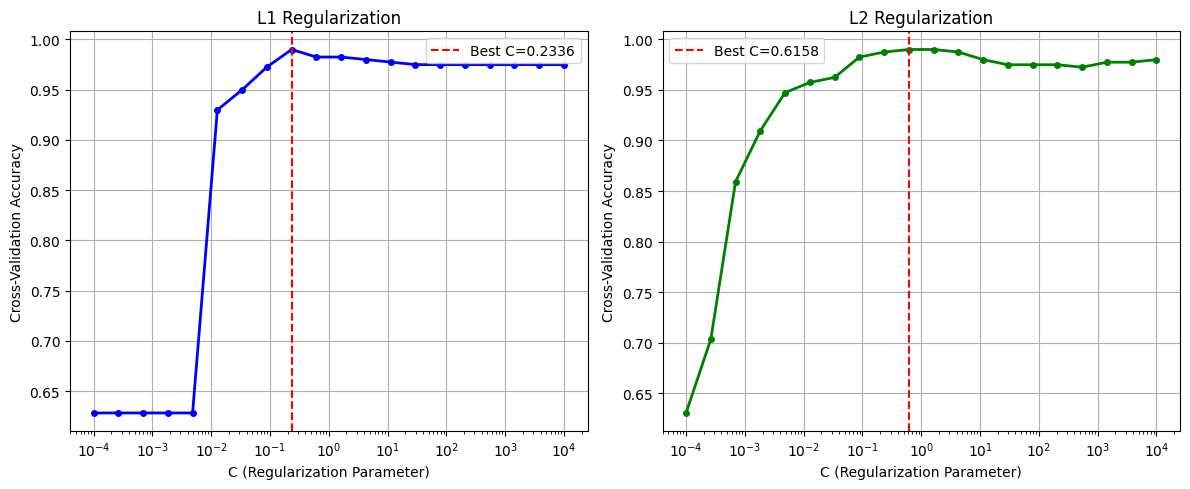

In [42]:
plt.figure(figsize=(12, 5))

# L1 plot
plt.subplot(1, 2, 1)
l1_scores = []
for C in C_values:
    lr_l1 = LogisticRegression(C=C, penalty='l1', solver='liblinear', random_state=42)
    scores = []
    cv_scores = cross_val_score(lr_l1, X_train_scaled, y_train, cv=5, scoring='accuracy')
    l1_scores.append(cv_scores.mean())

plt.semilogx(C_values, l1_scores, 'b-o', linewidth=2, markersize=4)
plt.axvline(lr_l1_cv.C_[0], color='red', linestyle='--', label=f'Best C={lr_l1_cv.C_[0]:.4f}')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('L1 Regularization')
plt.legend()
plt.grid(True)

# L2 plot
plt.subplot(1, 2, 2)
l2_scores = []
for C in C_values:
    lr_l2 = LogisticRegression(C=C, penalty='l2', random_state=42)
    cv_scores = cross_val_score(lr_l2, X_train_scaled, y_train, cv=5, scoring='accuracy')
    l2_scores.append(cv_scores.mean())

plt.semilogx(C_values, l2_scores, 'g-o', linewidth=2, markersize=4)
plt.axvline(lr_l2_cv.C_[0], color='red', linestyle='--', label=f'Best C={lr_l2_cv.C_[0]:.4f}')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('L2 Regularization')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
y_pred_l1 = lr_l1_cv.predict(X_test_scaled)
y_pred_l2 = lr_l2_cv.predict(X_test_scaled)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
accuracy_l2 = accuracy_score(y_test, y_pred_l2)

print(f"TEST SET RESULTS")
print(f"L1 Regularization Accuracy: {accuracy_l1:.4f}")
print(f"L2 Regularization Accuracy: {accuracy_l2:.4f}")



TEST SET RESULTS
L1 Regularization Accuracy: 0.9474
L2 Regularization Accuracy: 0.9591


In [52]:

print(classification_report(y_test, y_pred_l2, target_names=['Benign', 'Malignant']))

print(f"\nCONFUSION MATRIX (L2):")
cm = confusion_matrix(y_test, y_pred_l2)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97       107
   Malignant       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


CONFUSION MATRIX (L2):
TN: 106, FP: 1
FN: 6, TP: 58
